# GETTING STARTED 

In [171]:
# Importing libraries
import warnings
from sklearn.model_selection import train_test_split
from pmdarima.metrics import smape
from pmdarima.arima import auto_arima
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf


import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

In [172]:
# Loading data
df_sales = pd.read_csv('df_financial.csv', parse_dates=[0], usecols=[0,1], index_col='Date')

In [278]:
# Filtering the data until a particular pattern began in the Time Series data
df_sales = df_sales[:'2017-09']

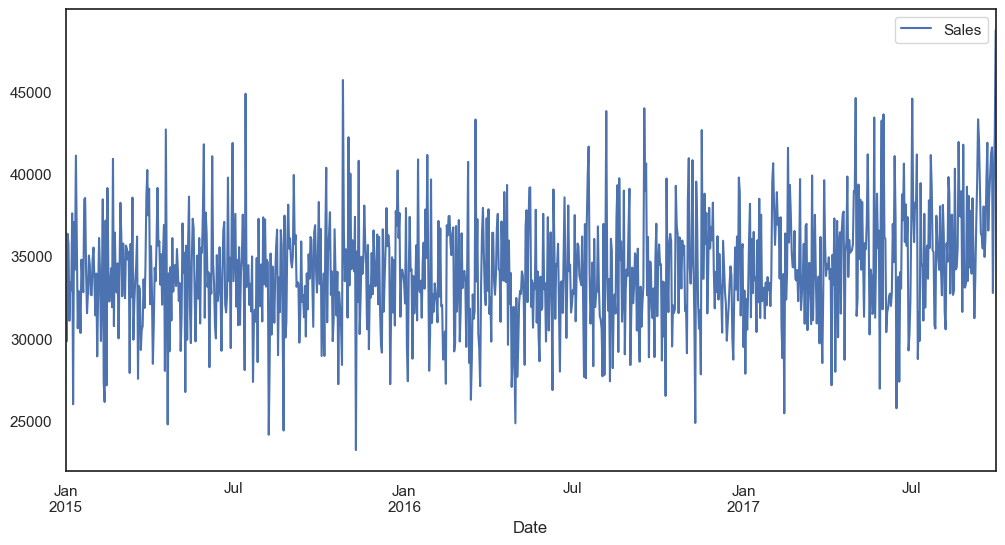

In [174]:
# Graphing Time Series data
df_sales.plot(figsize=(12,6))
plt.ticklabel_format(axis='y', style='plain');

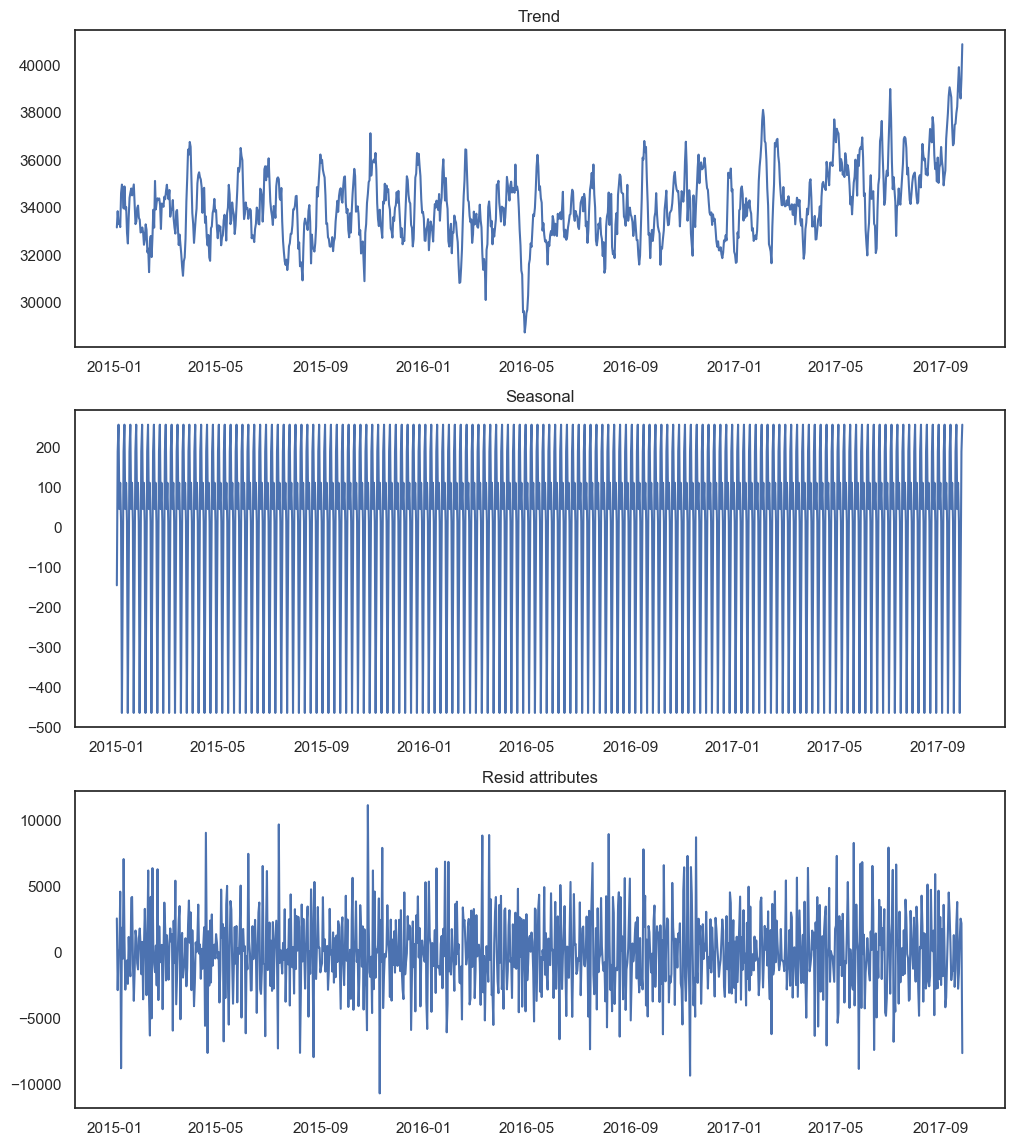

In [222]:
# Decomposing Times Series by Tren, Seasonal & Resid Attributes
season_analysis = seasonal_decompose(df_sales.Sales)


plt.figure(figsize=(12,14))

plt.subplot(3,1,1)
plt.plot(season_analysis.trend)
plt.ticklabel_format(axis='y', style='plain')
plt.title('Trend')

plt.subplot(3,1,2)
plt.plot(season_analysis.seasonal)
plt.title('Seasonal')

plt.subplot(3,1,3)
plt.plot(season_analysis.resid)
plt.title('Resid Attributes');

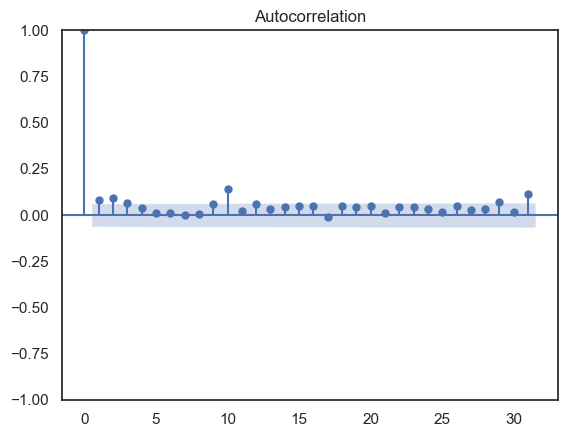

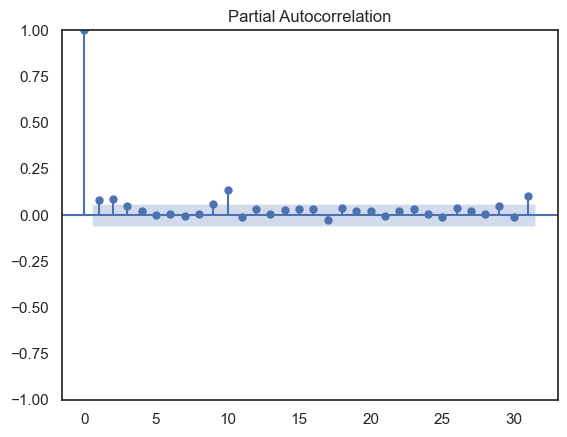

In [254]:
# Graphing Autocorrelation & Partial Autororrelation of Times Series
pm.plot_acf(df_sales, alpha=0.05)
pm.plot_pacf(df_sales, alpha=0.05);

# ARIMA MODEL

## Building Arima Model

In [177]:
# Auto Arima will helps on finding the best model with the least AIC
auto_arima_model = pm.auto_arima(
    df_sales, error_action='ignore', suppress_warnings=True, maxiter=50, seasonal=False)

# Arima Model (1,1,1) Summary
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1004
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -9594.052
Date:                Mon, 21 Nov 2022   AIC                          19196.104
Time:                        13:11:48   BIC                          19215.747
Sample:                    01-01-2015   HQIC                         19203.569
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.6379      2.016      1.805      0.071      -0.313       7.589
ar.L1          0.0524      0.031      1.705      0.088      -0.008       0.113
ma.L1         -0.9833      0.007   -132.055      0.000      -0.998      -0.969
sigma2      1.182e+07    8.5e-07   1.39e+13      0.000    1.18e+07    1.18e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                19.73
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.22
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.32e+28. Standard errors may be unstable.
"""

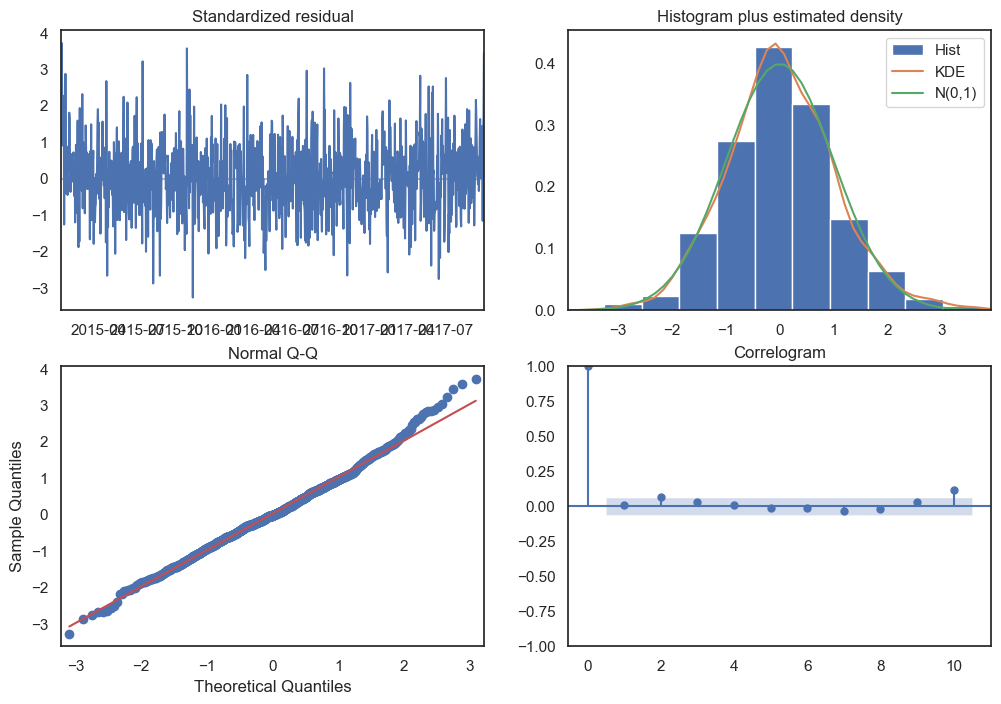

In [226]:
# Residual plots
auto_arima_model.plot_diagnostics(figsize=(12,8));

In [255]:
# A function for ARIMA model
def arima_func(time_series, p,d,q):
    
    arima_model = sm.tsa.statespace.SARIMAX(time_series, order=(p,d,q))
    arima_model_fit = arima_model.fit()
    arima_predict = arima_model_fit.predict()

# ARIMA Model (1,1,1)
arima_func(df_sales, 1,1,1)

## Graphing Actual Time Series vs Predicting Model

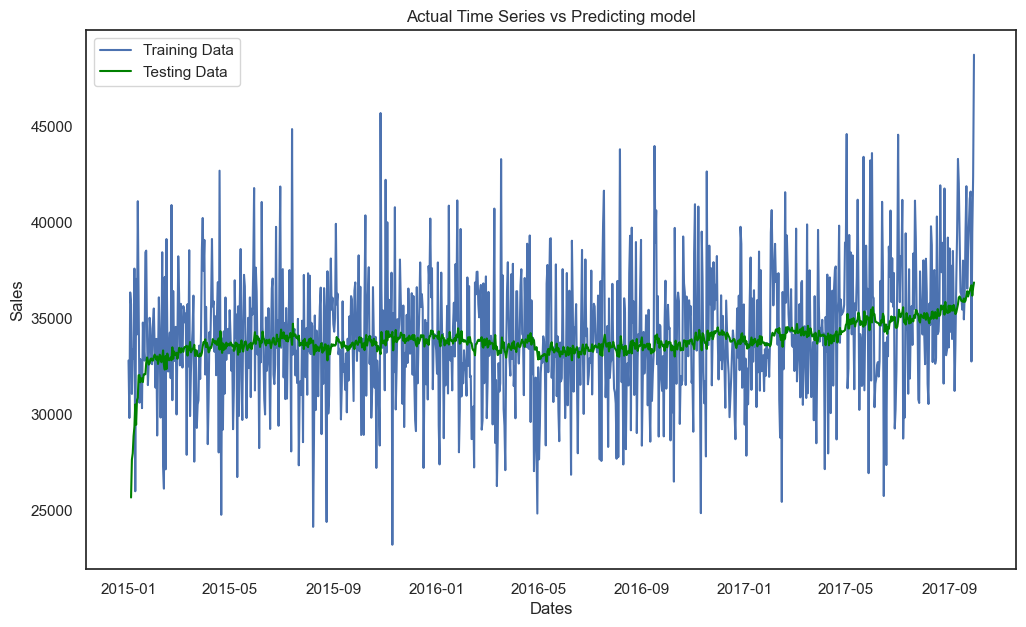

In [261]:
# Graphing actual Time Series vs Predicting output
plt.figure(figsize=(12, 7))
plt.plot(df_sales, label='Training Data')
plt.plot(arima_predict[3:], 'green', label='Testing Data')
plt.title('Actual Time Series vs Predicting model')
plt.xlabel('Dates')
plt.ylabel('Sales')
plt.legend();

## Accuracy Metrics

In [271]:
# A function for acurracy metrics
def accuracy_metrics(actual, predict):
    mape = np.mean(np.abs(predict - actual)/np.abs(actual))
    rmse = np.sqrt(mean_squared_error(actual, predict))
    mae = np.mean(np.abs(predict - actual))
    mse = mean_squared_error(actual, predict)
    r2 = r2_score(actual, predict)\
    
    print("Test MAPE: %.3f" % mape)
    print("Test RMSE: %.3f" % rmse)
    print("Test MAE: %.3f" % mae)
    print("Test MSE: %.3f" % mse)
    print("Test R2: %.3f" % r2)
    
accuracy_metrics(df_sales.Sales[1:], sarima_predict[1:])

Test MAPE: 0.079
Test RMSE: 3473.318
Test MAE: 2675.749
Test MSE: 12063934.604
Test R2: -0.013


# ARIMA TRAINING MODEL

## Building Arima Training Model (1,1,1)

In [184]:
# Splitting the data into train and test
train, test = train_test_split(df_sales, train_size=0.7, shuffle=False)

In [185]:
# Building model
train_model = sm.tsa.statespace.SARIMAX(train, order=(1, 1, 1))

train_model_fit = train_model.fit()

print(train_model_fit.summary())

In [207]:
#Forecast len(test) steps ahead
train_forecast = train_model_fit.get_forecast(steps=len(test))

#Confidence Intervals of the forecasted values
train_forecast_conf_int = train_forecast.conf_int(alpha=0.05)

# Make as pandas series
train_forecast_pm = train_forecast.predicted_mean
lower_series = train_forecast_conf_int.iloc[:,0]
upper_series = train_forecast_conf_int.iloc[:,1]

## Graphing Training vs Testing vs Forecasting Series

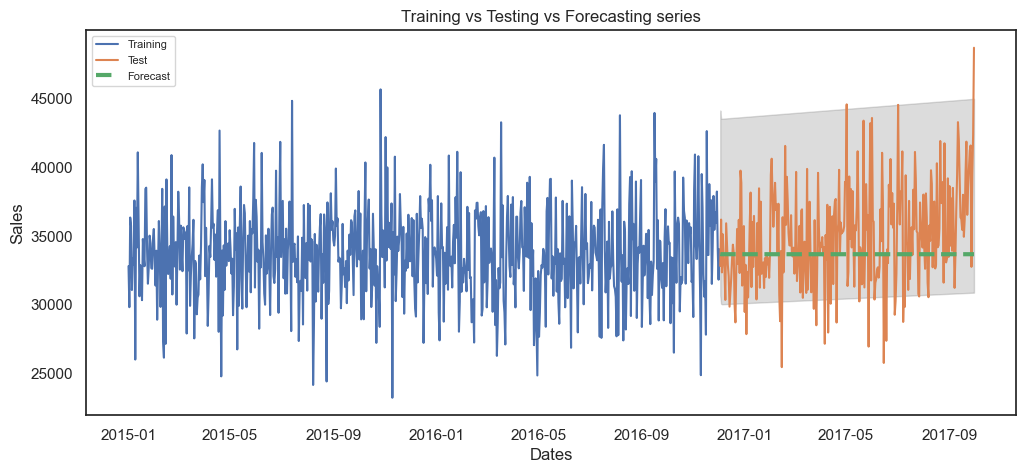

In [274]:
# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(train_forecast_pm, linestyle='dashed', label='Forecast', linewidth=3)
plt.fill_between(train_forecast_conf_int.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Training vs Testing vs Forecasting series')
plt.xlabel('Dates')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8);

## Accuracy Metrics

In [275]:
# Accuracy metrics
accuracy_metrics(test.Sales, train_forecast_pm)

Test MAPE: 0.082
Test RMSE: 3807.533
Test MAE: 2945.295
Test MSE: 14497306.248
Test R2: -0.141


# FORECASTING

## Building Forecasting Model

In [279]:
# Forecast n_periods steps ahead + Confidence Intervals of the forecasted values
n_periods = len(test)

forecast, conf_int = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)

In [210]:
# Make series for graphing Confidence Intervals
lower_series = pd.Series(conf_int[:, 0], index=forecast.index)
upper_series = pd.Series(conf_int[:, 1], index=forecast.index)

## Graphing Time Series + Forecast + Confidence Intervals

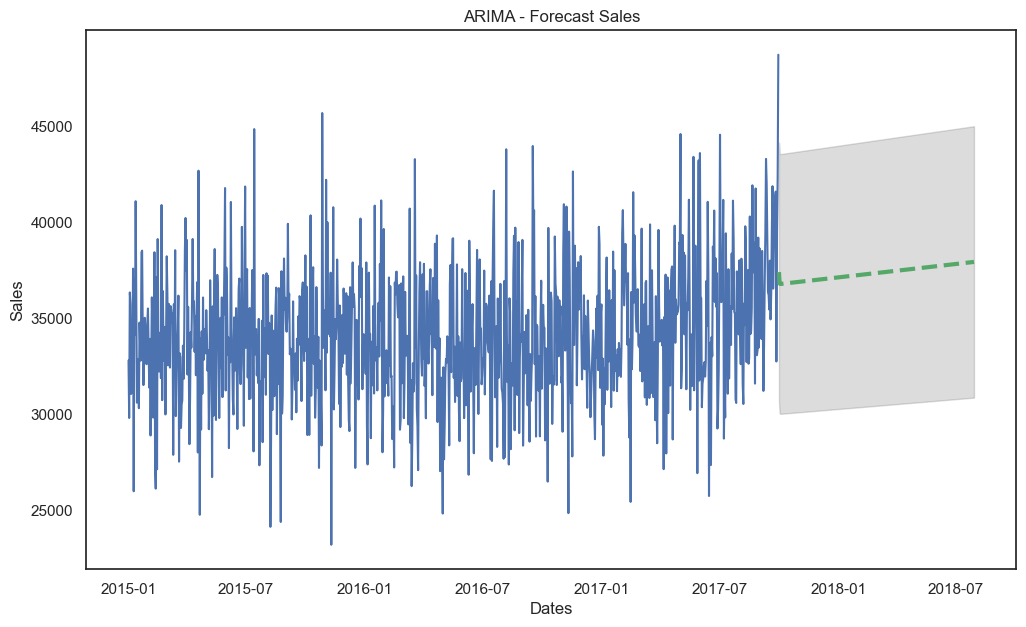

In [277]:
# Graphing Time Series + Forecast + Confidence Intervals
plt.figure(figsize=(12, 7))
plt.plot(df_sales)
plt.plot(forecast, color='g', linestyle='dashed', linewidth=3)
plt.fill_between(forecast.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.xlabel('Dates')
plt.ylabel('Sales')
plt.title("ARIMA - Forecast Sales");